# Fulvo Barca

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json

# Configuración para mostrar valores float con formato
pd.options.display.float_format = '{:,.2f}'.format

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Importa la biblioteca DuckDB para conectar a la base de datos en memoria
import duckdb
con = duckdb.connect(database=':memory:')

from keras.models import Sequential
from keras.layers import Dense
import datetime
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.random.set_seed(2007)

El código  `tf.random.set_seed(2007)` se utiliza para establecer la semilla aleatoria en TensorFlow. Establecer una semilla aleatoria garantiza que los resultados sean reproducibles, es decir, que al ejecutar el código varias veces, se obtendrán los mismos resultados.

In [3]:
def plot_train_history(history, title):
    """
    Grafica el historial de entrenamiento de un modelo de red neuronal.

    Parameters:
        history (tensorflow.keras.callbacks.History): Historial de entrenamiento del modelo.
        title (str): Título del gráfico.

    Returns:
        None
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
    plt.title(title)
    plt.legend()

    plt.show()

## Cargar los datos

In [4]:
T0708 = pd.read_table("2007 - 2008.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
T0809 = pd.read_table("2008 - 2009.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
T0910 = pd.read_table("season-0910.csv",delimiter=",",header=0,parse_dates=['Date'])
T1010=pd.read_table("season-1010.csv",delimiter=",",header=0)
T1010['Date'] = pd.to_datetime(T1010['Date'], format='%d/%m/%y')

C:\Users\Pc\AppData\Local\Temp\ipykernel_13000\2773967435.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  T0708 = pd.read_table("2007 - 2008.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
C:\Users\Pc\AppData\Local\Temp\ipykernel_13000\2773967435.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  T0809 = pd.read_table("2008 - 2009.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)


In [5]:

T1112 = pd.read_table("season-1112.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
T1213 = pd.read_table("season-1213.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
T1314 = pd.read_table("season-1314.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
T1415 = pd.read_table("season-1415.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
T1516 = pd.read_table("season-1516.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
T1617 = pd.read_table("season-1617.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)

C:\Users\Pc\AppData\Local\Temp\ipykernel_13000\2257828922.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  T1112 = pd.read_table("season-1112.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
C:\Users\Pc\AppData\Local\Temp\ipykernel_13000\2257828922.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  T1213 = pd.read_table("season-1213.csv", delimiter=",", header=0, parse_dates=['Date'], dayfirst=True)
C:\Users\Pc\AppData\Local\Temp\ipykernel_13000\2257828922.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  T1314 = pd.read_table("season-1314.csv", del

In [6]:
T0708['Temporada']= '2009-2008'
T0809['Temporada']= '2008-2009'
T0910['Temporada'] = '2009-2010'
T1010['Temporada'] = '2010-2011'
T1112['Temporada'] = '2011-2012'
T1213['Temporada'] = '2012-2013'
T1314['Temporada'] = '2013-2014'
T1415['Temporada'] = '2014-2015'
T1516['Temporada'] = '2015-2016'
T1617['Temporada'] = '2016-2017'

In [7]:
df = pd.concat([T0708,T0809,T0910,T1010,T1112, T1213,T1314,T1415,T1516,T1617], ignore_index=True)
df = df.loc[:,['Temporada', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR','B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA']]
df = df.sort_values(['HomeTeam',"Date"], ascending=[True, True])
df

,Temporada,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA
3436,2016-2017,2016-08-28,Alaves,Sp Gijon,0,0,D,0,0,D,...,1,1,0,0,2.15,3.20,3.75,2.15,3.25,3.60
3459,2016-2017,2016-09-19,Alaves,La Coruna,0,0,D,0,0,D,...,3,4,0,0,2.30,3.00,3.50,2.20,3.20,3.30
3479,2016-2017,2016-09-26,Alaves,Granada,3,1,H,0,0,D,...,3,3,0,0,2.10,3.30,3.75,2.05,3.40,3.70
3495,2016-2017,2016-10-16,Alaves,Malaga,1,1,D,1,0,H,...,3,3,1,1,2.60,3.00,3.00,2.60,3.00,3.00
3511,2016-2017,2016-10-29,Alaves,Real Madrid,1,4,A,1,2,A,...,5,1,0,0,13.00,6.50,1.22,13.00,7.00,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,2012-2013,2013-04-14,Zaragoza,Barcelona,0,3,A,0,2,A,...,3,2,0,0,7.50,4.75,1.40,7.00,4.40,1.44
2224,2012-2013,2013-04-27,Zaragoza,Mallorca,3,2,H,1,1,D,...,4,2,0,0,2.10,3.30,3.50,2.10,3.25,3.60
2238,2012-2013,2013-05-05,Zaragoza,Vallecano,3,0,H,1,0,H,...,4,2,0,0,2.00,3.50,3.60,2.00,3.50,3.60
2258,2012-2013,2013-05-19,Zaragoza,Ath Bilbao,1,2,A,1,0,H,...,5,2,0,0,1.85,3.50,4.20,1.83,3.60,4.10


## Agregar más características

In [8]:
Equipos = con.execute("""
    SELECT Temporada ,Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, HS, HST, "AS", AST, HR, AR,
    CASE
        WHEN FTHG > FTAG THEN 3
        WHEN FTHG = FTAG THEN 1
        ELSE 0 
    END AS HP,
    CASE
        WHEN FTHG < FTAG THEN 3
        WHEN FTHG = FTAG THEN 1
        ELSE 0
    END AS AP,
    CASE
        WHEN FTHG > FTAG THEN 1
        ELSE 0
    END AS IPH,
    CASE
        WHEN FTHG < FTAG THEN 1
        ELSE 0
    END AS IPA
    FROM df
""").df()

Equipos

,Temporada,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,HST,AS,AST,HR,AR,HP,AP,IPH,IPA
0,2016-2017,2016-08-28,Alaves,Sp Gijon,0,0,D,13,2,7,1,0,0,1,1,0,0
1,2016-2017,2016-09-19,Alaves,La Coruna,0,0,D,9,1,16,1,0,0,1,1,0,0
2,2016-2017,2016-09-26,Alaves,Granada,3,1,H,16,6,13,3,0,0,3,0,1,0
3,2016-2017,2016-10-16,Alaves,Malaga,1,1,D,8,4,12,5,1,1,1,1,0,0
4,2016-2017,2016-10-29,Alaves,Real Madrid,1,4,A,8,3,15,5,0,0,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,2012-2013,2013-04-14,Zaragoza,Barcelona,0,3,A,12,2,11,6,0,0,0,3,0,1
3796,2012-2013,2013-04-27,Zaragoza,Mallorca,3,2,H,13,6,11,4,0,0,3,0,1,0
3797,2012-2013,2013-05-05,Zaragoza,Vallecano,3,0,H,16,6,7,3,0,0,3,0,1,0
3798,2012-2013,2013-05-19,Zaragoza,Ath Bilbao,1,2,A,14,3,10,4,0,0,0,3,0,1


Este código ejecuta una consulta SQL utilizando la biblioteca DuckDB y carga los resultados en el DataFrame "Equipos". La consulta SQL selecciona las columnas 'Temporada', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'HST', 'AS', 'AST', 'HR', 'AR' de la tabla 'df'. También realiza algunas transformaciones utilizando las cláusulas CASE para calcular las puntuaciones y los indicadores de victoria/derrota del equipo local y visitante. Luego, los resultados se cargan en el DataFrame "Equipos" para su posterior uso.

In [9]:
H = con.execute("""
    SELECT Temporada,Date, HomeTeam AS Equipo, FTHG AS "Goles a Favor", FTAG AS "Goles en Contra", HP AS Puntos, IPH AS "Partido Ganado", HS AS "Tiros", HST AS "Tiros al Arco"
    FROM Equipos
""").df()

V = con.execute("""
    SELECT Temporada,Date, AwayTeam AS Equipo, FTHG AS "Goles en Contra", FTAG AS "Goles a Favor", AP AS Puntos, IPA AS "Partido Ganado", "AS" AS "Tiros", AST AS "Tiros al Arco"
    FROM Equipos
""").df()

Equipos = pd.concat([H, V], ignore_index=True)
Equipos = Equipos.sort_values(['Equipo', 'Date'], ascending=[True, True])
Equipos

,Temporada,Date,Equipo,Goles a Favor,Goles en Contra,Puntos,Partido Ganado,Tiros,Tiros al Arco
4294,2016-2017,2016-08-21,Alaves,1,1,1,0,2,1
0,2016-2017,2016-08-28,Alaves,0,0,1,0,13,2
4485,2016-2017,2016-09-10,Alaves,2,1,3,1,5,4
1,2016-2017,2016-09-19,Alaves,0,0,1,0,9,1
7108,2016-2017,2016-09-22,Alaves,1,2,0,0,8,1
...,...,...,...,...,...,...,...,...,...
3797,2012-2013,2013-05-05,Zaragoza,3,0,3,1,16,6
5621,2012-2013,2013-05-10,Zaragoza,0,0,1,0,16,3
3798,2012-2013,2013-05-19,Zaragoza,1,2,0,0,14,3
4578,2012-2013,2013-05-26,Zaragoza,0,4,0,0,16,3


1. Se ejecuta una consulta SQL para seleccionar las columnas relevantes para los equipos locales (H) y se asigna a la variable "H". La consulta incluye las columnas 'Temporada', 'Date', 'HomeTeam' (renombrada como 'Equipo'), 'FTHG' (renombrada como 'Goles a Favor'), 'FTAG' (renombrada como 'Goles en Contra'), 'HP' (renombrada como 'Puntos'), 'IPH' (renombrada como 'Partido Ganado'), 'HS' (renombrada como 'Tiros') y 'HST' (renombrada como 'Tiros al Arco').
2. Se ejecuta una consulta SQL similar para los equipos visitantes (V) y se asigna a la variable "V". La consulta selecciona las mismas columnas, pero con modificaciones correspondientes para los equipos visitantes.
3. Se utiliza la función pd.concat para combinar los DataFrames "H" y "V" en un solo DataFrame llamado "Equipos". La opción ignore_index=True se utiliza para reindexar el DataFrame resultante.
4. Se ordena el DataFrame "Equipos" por 'Equipo' y 'Date' en orden ascendente.

In [10]:
# Obtener temporadas únicas
temporadas = Equipos['Temporada'].unique()

# Iterar sobre cada temporada
for temporada in temporadas:
    # Filtrar los datos por temporada
    Equipos_temporada = Equipos[Equipos['Temporada'] == temporada]
    
    # Calcular los valores acumulativos por equipo en la temporada
    goles_favor_acumulados = Equipos_temporada.groupby('Equipo')['Goles a Favor'].cumsum()
    goles_contra_acumulados = Equipos_temporada.groupby('Equipo')['Goles en Contra'].cumsum()
    partidos_ganados_acumulados = Equipos_temporada.groupby('Equipo')['Partido Ganado'].cumsum()
    tiros_acumulados = Equipos_temporada.groupby('Equipo')['Tiros'].cumsum()
    tiros_al_arco_acumulados = Equipos_temporada.groupby('Equipo')['Tiros al Arco'].cumsum()
    puntos_favor_acumulados = Equipos_temporada.groupby('Equipo')['Puntos'].cumsum()
    
    # Agregar las columnas de valores acumulativos al DataFrame original
    Equipos.loc[Equipos['Temporada'] == temporada, 'Puntos'] = puntos_favor_acumulados
    Equipos.loc[Equipos['Temporada'] == temporada, 'Goles a Favor'] = goles_favor_acumulados
    Equipos.loc[Equipos['Temporada'] == temporada, 'Goles en Contra'] = goles_contra_acumulados
    Equipos.loc[Equipos['Temporada'] == temporada, 'Partidos Ganados'] = partidos_ganados_acumulados
    Equipos.loc[Equipos['Temporada'] == temporada, 'Tiros'] = tiros_acumulados
    Equipos.loc[Equipos['Temporada'] == temporada, 'Tiros al Arco'] = tiros_al_arco_acumulados

1. Se obtienen las temporadas únicas presentes en el DataFrame "Equipos".
2. Se itera sobre cada temporada y se realiza el cálculo de los valores acumulativos por equipo en esa temporada.
3. Los valores acumulativos se calculan utilizando el método cumsum() en las columnas correspondientes.
4. Las columnas de valores acumulativos se agregan al DataFrame original "Equipos" utilizando la función loc y filtrando por temporada.
5. Se repite el proceso para cada temporada.

In [11]:
# Iterar sobre cada temporada
for temporada in temporadas:
    # Filtrar los datos por temporada
    equipos_temporada = Equipos[Equipos['Temporada'] == temporada]
    
    # Obtener los equipos únicos en la temporada
    equipos = equipos_temporada['Equipo'].unique()
    
    # Lista para almacenar los últimos partidos de la temporada
    ultimos_partidos_temporada = []
    
    # Iterar sobre cada equipo
    for equipo in equipos:
        # Filtrar por equipo y temporada
        equipo_temporada = equipos_temporada[equipos_temporada['Equipo'] == equipo]
        
        # Obtener el último partido del equipo
        ultimo_partido = equipo_temporada.iloc[-1]
        
        # Agregar el último partido a la lista
        ultimos_partidos_temporada.append(ultimo_partido)
    
    # Crear DataFrame con los últimos partidos de la temporada
    ultimos_partidos_temporada = pd.concat(ultimos_partidos_temporada, axis=1).T
    
    # Ordenar los partidos por puntos en orden descendente
    ultimos_partidos_temporada = ultimos_partidos_temporada.sort_values('Puntos', ascending=False)
    
    # Mostrar los datos del último partido de los equipos por temporada
    print(f"Temporada: {temporada}")
    print(ultimos_partidos_temporada[['Puntos', 'Equipo', 'Goles a Favor', 'Goles en Contra', 'Partido Ganado', 'Tiros', 'Tiros al Arco']])
    print("-------------------------")
# Comparar con tablas oficiales para comprobar la correcta generación de las nuevas características
# y validar los resultados obtenidos

Temporada: 2016-2017
     Puntos       Equipo Goles a Favor Goles en Contra Partido Ganado Tiros  \
5851     93  Real Madrid           106              41              1   661   
702      90    Barcelona           116              37              1   648   
512      78   Ath Madrid            70              27              1   502   
2868     72      Sevilla            69              49              1   486   
7124     67   Villarreal            56              33              1   425   
4730     64     Sociedad            59              53              0   487   
4312     63   Ath Bilbao            53              43              0   478   
5319     56      Espanol            49              50              1   343   
5547     55       Alaves            41              43              0   389   
4502     54        Eibar            56              51              0   449   
2051     46       Malaga            49              55              0   491   
3324     46     Valencia       

1. Se itera sobre cada temporada y se realiza el análisis de los últimos partidos de cada equipo.
2. Se filtran los datos por temporada.
3. Se obtienen los equipos únicos presentes en la temporada.
4. Se crea una lista llamada "ultimos_partidos_temporada" para almacenar los últimos partidos de la temporada.
5. Se itera sobre cada equipo y se realiza el análisis del último partido de cada equipo en la temporada.
6. Se agrega el último partido a la lista de últimos partidos de la temporada.
7. Se crea un DataFrame llamado "ultimos_partidos_temporada" utilizando la función pd.concat para combinar los datos de los últimos partidos de todos los equipos en la temporada.
8. Se ordenan los partidos por puntos en orden descendente.
9. Se muestra el título de la temporada y se imprimen los datos del último partido de los equipos por temporada.
10. Se imprime una línea separadora para mayor claridad en la salida.

In [12]:
# Ordenar los equipos por nombre y fecha
# Esto asegura que los equipos estén ordenados alfabéticamente y los partidos estén ordenados cronológicamente dentro de cada equipo
Equipos = Equipos.sort_values(["Equipo","Date"], ascending=[True,True])
Equipos

,Temporada,Date,Equipo,Goles a Favor,Goles en Contra,Puntos,Partido Ganado,Tiros,Tiros al Arco,Partidos Ganados
4294,2016-2017,2016-08-21,Alaves,1,1,1,0,2,1,0.00
0,2016-2017,2016-08-28,Alaves,1,1,2,0,15,3,0.00
4485,2016-2017,2016-09-10,Alaves,3,2,5,1,20,7,1.00
1,2016-2017,2016-09-19,Alaves,3,2,6,0,29,8,1.00
7108,2016-2017,2016-09-22,Alaves,4,4,6,0,37,9,1.00
...,...,...,...,...,...,...,...,...,...,...
3797,2012-2013,2013-05-05,Zaragoza,35,53,33,1,399,131,9.00
5621,2012-2013,2013-05-10,Zaragoza,35,53,34,0,415,134,9.00
3798,2012-2013,2013-05-19,Zaragoza,36,55,34,0,429,137,9.00
4578,2012-2013,2013-05-26,Zaragoza,36,59,34,0,445,140,9.00


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Definir las columnas categóricas a normalizar
cat_cols2 = ['Date', 'Temporada', 'Equipo']
cat_cols = ['FTR']

# Eliminar la columna de tipo datetime64
# Eliminamos las columnas categóricas ya que queremos normalizar solo las variables numéricas
df_num = Equipos.drop(columns=cat_cols2)

# Guardar los nombres de las variables numéricas
num_cols = df_num.columns

# Normalizar las variables numéricas
scaler = MinMaxScaler()
df_num = scaler.fit_transform(df_num.select_dtypes(include=['number']))
df_num = pd.DataFrame(df_num, columns=num_cols)

# Concatenar las variables categóricas y las variables numéricas normalizadas
df_processed = pd.concat([Equipos.loc[:,['Temporada', 'Date', 'Equipo']], df_num], axis=1)

In [14]:
Equipos=df_processed


In [15]:
# Obtener los datos de los partidos de equipos locales
C = con.execute("""
    SELECT H.Date, 
    H.Equipo,
    Equipos."Goles a Favor" as GF_local,
    Equipos."Goles en Contra" as GC_local,
    Equipos.Puntos as Pts_local,
    Equipos."Partido Ganado" as PG_local,
    Equipos.Tiros as Tiros_local,
    Equipos."Tiros al Arco" as "Tiros Arco_local",
    Equipos."Partidos Ganados" as "Partidos Ganados_local"
    FROM H
    LEFT JOIN Equipos ON H.Date = Equipos.Date AND H.Equipo = Equipos.Equipo
""").df()

# Obtener los datos de los partidos de equipos visitantes
V = con.execute("""
    SELECT 
    V.Date, 
    V.Equipo,
    Equipos."Goles a Favor" as GF_Visitante,
    Equipos."Goles en Contra" as GC_Visitante,
    Equipos.Puntos as Pts_Visitante,
    Equipos."Partido Ganado" as PG_Visitante,
    Equipos.Tiros as Tiros_Visitante,
    Equipos."Tiros al Arco" as "Tiros Arco_Visitante",
    Equipos."Partidos Ganados" as "Partidos Ganados_Visitante"
    FROM V
    LEFT JOIN Equipos ON V.Date = Equipos.Date AND V.Equipo = Equipos.Equipo
""").df()

1. En la consulta para los equipos locales (C), se seleccionan las columnas necesarias, como la fecha del partido (H.Date), el nombre del equipo (H.Equipo), los goles a favor del equipo local (Equipos."Goles a Favor"), los goles en contra del equipo local (Equipos."Goles en Contra"), los puntos del equipo local (Equipos.Puntos), los partidos ganados del equipo local (Equipos."Partido Ganado"), los tiros del equipo local (Equipos.Tiros), los tiros al arco del equipo local (Equipos."Tiros al Arco") y los partidos ganados acumulados del equipo local (Equipos."Partidos Ganados").
2. 
Se realiza una unión izquierda (LEFT JOIN) con la tabla Equipos utilizando las columnas de fecha (H.Date) y equipo (H.Equipo).
3. 
En la consulta para los equipos visitantes (V), se realizan pasos similares a la consulta de equipos locales, pero se seleccionan las columnas correspondientes a los equipos visitantes
4. .
Al finalizar, se obtienen dos DataFrames (C y V) que contienen los datos de los partidos de los equipos locales y visitantes, respectivamente.

In [16]:
V

,Date,Equipo,GF_Visitante,GC_Visitante,Pts_Visitante,PG_Visitante,Tiros_Visitante,Tiros Arco_Visitante,Partidos Ganados_Visitante
0,2016-08-28,Sp Gijon,0.02,0.00,0.03,1.00,0.01,0.01,0.03
1,2016-09-26,Granada,0.03,0.03,0.03,0.00,0.05,0.04,0.03
2,2016-10-16,Malaga,0.04,0.05,0.03,0.00,0.06,0.06,0.03
3,2016-10-29,Real Madrid,0.04,0.07,0.03,0.00,0.07,0.06,0.03
4,2016-11-20,Espanol,0.05,0.09,0.04,0.00,0.09,0.08,0.03
...,...,...,...,...,...,...,...,...,...
3795,2011-10-15,Betis,0.02,0.06,0.03,0.00,0.05,0.03,0.03
3796,2009-11-29,La Coruna,0.07,0.06,0.13,1.00,0.11,0.12,0.12
3797,2010-01-23,Almeria,0.34,0.43,0.39,1.00,0.49,0.42,0.34
3798,2009-09-13,Almeria,0.19,0.39,0.16,0.00,0.24,0.22,0.09


In [17]:
# Obtener la frecuencia de aparición de cada equipo
frecuencia = Equipos['Equipo'].value_counts()

# Obtener una lista de identificadores únicos
identificadores_unicos = Equipos['Equipo'].unique()

# Crear diccionarios vacíos para almacenar los DataFrames resultantes
dfC = {}
dfV = {}

# Ordenar el DataFrame C por Equipo y Date en orden descendente
C = C.sort_values(['Equipo', 'Date'], ascending=[False, False])

# Dividir el DataFrame C en múltiples DataFrames según el identificador
for id in identificadores_unicos:
    x = C[C['Equipo'] == id]
    x = x.reset_index(drop=True)
    dfC[id] = x.drop(['Equipo'], axis=1).values

# Ordenar el DataFrame V por Equipo y Date en orden descendente
V = V.sort_values(['Equipo', 'Date'], ascending=[False, False])

# Dividir el DataFrame V en múltiples DataFrames según el identificador
for id in identificadores_unicos:
    x = V[V['Equipo'] == id]
    x = x.reset_index(drop=True)
    dfV[id] = x.drop(['Equipo'], axis=1).values


# Crear un diccionario vacío para almacenar los DataFrames resultantes
dataframes = {}

# Ordenar el DataFrame Equipos por Equipo y Date en orden descendente
Equipos = Equipos.sort_values(['Equipo', 'Date'], ascending=[False, False])

# Dividir el DataFrame Equipos en múltiples DataFrames según el identificador
for id in identificadores_unicos:
    x = Equipos[Equipos['Equipo'] == id]
    x = x.reset_index(drop=True)
    dataframes[id] = x.drop(['Equipo', 'Temporada'], axis=1).values

Este código permite almacenar las nuevas características de los partidos de cada equipo, ya sea como local o visitante, en diccionarios separados (dfC para partidos como local, dfV para partidos como visitante) o en un diccionario conjunto (dataframes) que contiene ambos casos.

In [18]:
def agregar_columna(df, valor):
    columna = np.full((df.shape[0], 1), valor, dtype=df.dtype)  # Crear una columna con el valor especificado
    nuevo_df = np.concatenate((columna, df), axis=1)  # Concatenar la nueva columna al inicio del dataframe
    
    return nuevo_df

In [19]:
def multivariate_data(dataset, diccionario, diccionario2, identificador_df, identificado_df2, identificador_d, target,
                      start_index, end_index, history_size, target_size, step, single_step=False, same=False):
    ''' 
    dataset: conjunto de datos para las secuencias de entrada
    diccionario: diccionario que contiene un conjunto de características relacionadas con el dataset
    identificador_df: identificador que nos ubica el individuo dentro del diccionario dataset2
    identificado_df2: identificador adicional para otro dataset en el diccionario (opcional)
    identificador_d: identificador que nos indica a partir de qué observación en el df del diccionario debemos tomar
    target: conjunto de datos para las secuencias de salida
    start_index: índice inicial desde donde empezar a tomar los datos
    end_index: índice final para tomar los datos. None para tomarlos todos
    history_size: tamaño de la ventana para crear las secuencias
    target_size: dentro de cuántas observaciones futuras deseas pronosticar
    step: cada cuántas observaciones deben tomarse. Para secuencias muy largas que no cambian mucho localmente
    single_step: predecir solamente un valor futuro (=True), o predecir todos los valores hasta target_size(=False)
    '''  
    if diccionario2 is None:
        data = []
        labels = []

        start_index = start_index + history_size
        if end_index is None:
            end_index = len(dataset) - target_size

        for i in range(start_index, end_index):
            valor1 = dataset.iloc[i][identificador_df]
            valor2 = dataset.iloc[i][identificador_d]
            df = diccionario[valor1]
            indice_valor2 = np.where(df == valor2)
            indices = range(indice_valor2[0][0] + 1, indice_valor2[0][0] + history_size + 1, step)
            df = np.delete(df, indice_valor2[1][0], axis=1)
            try:
                data.append(df[indices])
                if single_step:
                    labels.append(target[i])
                else:
                    labels.append(target[i:i + target_size])
            except IndexError:
                pass

        return np.array(data), np.array(labels)
    else:
        if same==False:
    
            data1 = []
            data2 = []
            labels = []
            for i in range(start_index, end_index):
                valor1 = dataset.iloc[i][identificador_df]
                valor2 = dataset.iloc[i][identificador_d]
                df = diccionario[valor1]
                indice_valor2 = np.where(df == valor2)
                indices =  range(indice_valor2[0][0]+1, indice_valor2[0][0] + history_size +1, step)
                df = np.delete(df, indice_valor2[1][0], axis=1)

                valor1 = dataset.iloc[i][identificado_df2]
                valor2 = dataset.iloc[i][identificador_d]
                df2 = diccionario2[valor1]
                indice_valor2 = np.where(df2 == valor2)
                indices2 = range(indice_valor2[0][0]+1, indice_valor2[0][0] + history_size +1, step)
                df2 = np.delete(df2, indice_valor2[1][0], axis=1)

                try:
                    data1.append(df[indices])
                    data2.append(df2[indices2])
                    if single_step:
                        labels.append(target[i + target_size])
                    else:
                        labels.append(target[i:i + target_size])
                except IndexError:
                    pass

            return np.array(data1), np.array(data2), np.array(labels)
        else:
            data3=[]
            data1 = []
            data2 = []
            labels = []
            for i in range(start_index, end_index):
                valor1 = dataset.iloc[i][identificador_df]
                valor2 = dataset.iloc[i][identificador_d]
                df = diccionario[valor1]
                indice_valor2 = np.where(df == valor2)
                indices = range(indice_valor2[0][0]+1, indice_valor2[0][0] + history_size +1, step)
                df = np.delete(df, indice_valor2[1][0], axis=1)

                valor1 = dataset.iloc[i][identificado_df2]
                valor2 = dataset.iloc[i][identificador_d]
                df2 = diccionario2[valor1]
                indice_valor2 = np.where(df2 == valor2)
                indices2 = range(indice_valor2[0][0]+1,indice_valor2[0][0] + history_size +1, step)
                df2 = np.delete(df2, indice_valor2[1][0], axis=1)

                try:
                    data3.append(np.vstack((agregar_columna(df[indices],1), agregar_columna(df2[indices2],0))))
                    data1.append(df[indices])
                    data2.append(df2[indices2])
                    if single_step:
                        labels.append(target[i + target_size])
                    else:
                        labels.append(target[i:i + target_size])
                except IndexError:
                    pass

            return np.array(data1), np.array(data2),np.array(data3),np.array(labels)

La función multivariate_data toma diferentes argumentos para procesar los datos de entrada y salida en secuencias de tamaño history_size y pronosticar los valores futuros. Dependiendo de los argumentos proporcionados, la función puede manejar diferentes escenarios de datos univariados o multivariados.

In [20]:
from sklearn.preprocessing import MinMaxScaler
cat_cols2 = ['Date','Temporada', 'HomeTeam', 'AwayTeam','FTR','HTR']
cat_cols = ['FTR']

# Codificar las variables categóricas usando one-hot encoding
df_cat = pd.get_dummies(df[cat_cols])
df_cat = df_cat.reset_index(drop=True)

df_processed = pd.concat([df,df_cat], axis=1)
df=df_processed

El código realiza el proceso de codificación de variables categóricas utilizando "one-hot encoding" en el dataframe df. Las variables categóricas especificadas en la lista cat_cols se transforman en representaciones numéricas mediante la creación de nuevas columnas binarias para cada categoría. El resultado se concatena al dataframe original y se almacena en df_processed,

In [21]:
df

,Temporada,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AR,B365H,B365D,B365A,BWH,BWD,BWA,FTR_A,FTR_D,FTR_H
3436,2016-2017,2016-08-28,Alaves,Sp Gijon,0,0,D,0,0,D,...,0,2.15,3.20,3.75,2.15,3.25,3.60,True,False,False
3459,2016-2017,2016-09-19,Alaves,La Coruna,0,0,D,0,0,D,...,0,2.30,3.00,3.50,2.20,3.20,3.30,True,False,False
3479,2016-2017,2016-09-26,Alaves,Granada,3,1,H,0,0,D,...,0,2.10,3.30,3.75,2.05,3.40,3.70,False,False,True
3495,2016-2017,2016-10-16,Alaves,Malaga,1,1,D,1,0,H,...,1,2.60,3.00,3.00,2.60,3.00,3.00,True,False,False
3511,2016-2017,2016-10-29,Alaves,Real Madrid,1,4,A,1,2,A,...,0,13.00,6.50,1.22,13.00,7.00,1.20,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,2012-2013,2013-04-14,Zaragoza,Barcelona,0,3,A,0,2,A,...,0,7.50,4.75,1.40,7.00,4.40,1.44,True,False,False
2224,2012-2013,2013-04-27,Zaragoza,Mallorca,3,2,H,1,1,D,...,0,2.10,3.30,3.50,2.10,3.25,3.60,False,True,False
2238,2012-2013,2013-05-05,Zaragoza,Vallecano,3,0,H,1,0,H,...,0,2.00,3.50,3.60,2.00,3.50,3.60,True,False,False
2258,2012-2013,2013-05-19,Zaragoza,Ath Bilbao,1,2,A,1,0,H,...,0,1.85,3.50,4.20,1.83,3.60,4.10,False,True,False


In [22]:
# Crear una nueva columna 'd' concatenando las columnas 'HomeTeam' y 'AwayTeam'
df['d'] = df['HomeTeam'] + df['AwayTeam']

# Contar las ocurrencias de cada valor en la columna 'd'
conteo = df['d'].value_counts()

# Crear una nueva columna 'd2' concatenando las columnas 'AwayTeam' y 'HomeTeam'
df['d2'] = df['AwayTeam'] + df['HomeTeam']

# Contar las ocurrencias de cada valor en la columna 'd2'
conteo2 = df['d2'].value_counts()

# Filtrar los valores que aparecen menos de tres veces en la columna 'd'
valores_filtrados = conteo[conteo >= 3].index.tolist()

# Filtrar el DataFrame original manteniendo solo las filas con valores filtrados en la columna 'd'
df_filtrado = df.groupby('d').filter(lambda x: x.name in valores_filtrados)
df = df_filtrado

# Eliminar la columna 'd' del DataFrame final
df.drop('d', axis=1, inplace=True)

# Filtrar los valores que aparecen menos de tres veces en la columna 'd2'
valores_filtrados2 = conteo2[conteo2 >= 3].index.tolist()

# Filtrar el DataFrame original manteniendo solo las filas con valores filtrados en la columna 'd2'
df_filtrado = df_filtrado.groupby('d2').filter(lambda x: x.name in valores_filtrados)
df = df_filtrado

# Eliminar la columna 'd2' del DataFrame final
df.drop('d2', axis=1, inplace=True)

Estas operaciones buscan filtrar los datos para mantener solo las observaciones que involucran equipos que han jugado al menos tres partidos.

In [23]:
df = df.sort_values(["Date"], ascending=[True])
df

,Temporada,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AR,B365H,B365D,B365A,BWH,BWD,BWA,FTR_A,FTR_D,FTR_H
1,2009-2008,2007-08-25,Sevilla,Getafe,4,1,H,0,1,A,...,2,1.40,4.00,9.00,1.40,4.00,7.25,False,True,False
0,2009-2008,2007-08-25,Real Madrid,Ath Madrid,2,1,H,1,1,D,...,0,1.72,3.50,4.75,1.75,3.45,4.20,False,True,False
3,2009-2008,2007-08-26,Espanol,Valladolid,0,1,A,0,0,D,...,0,1.83,3.25,4.50,1.70,3.30,4.80,False,True,False
8,2009-2008,2007-08-26,Santander,Barcelona,0,0,D,0,0,D,...,0,7.50,4.00,1.44,6.50,3.85,1.45,False,True,False
4,2009-2008,2007-08-26,La Coruna,Almeria,0,3,A,0,2,A,...,0,1.72,3.40,5.00,1.55,3.65,5.50,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,2016-2017,2017-05-21,Valencia,Villarreal,1,3,A,0,1,A,...,0,3.10,3.40,2.30,3.00,3.50,2.30,True,False,False
3797,2016-2017,2017-05-21,Celta,Sociedad,2,2,D,0,0,D,...,0,4.75,3.75,1.75,4.50,3.80,1.78,False,False,True
3795,2016-2017,2017-05-21,Ath Madrid,Ath Bilbao,3,1,H,2,0,H,...,0,2.00,3.50,3.80,2.00,3.40,3.90,True,False,False
3798,2016-2017,2017-05-21,Malaga,Real Madrid,0,2,A,0,1,A,...,0,11.00,7.00,1.22,11.50,7.00,1.22,True,False,False


In [24]:
past_history=4
future_target = 1
STEP = 1
targets=  ['FTR_A','FTR_D','FTR_H']
Local= df[df['HomeTeam'] == 'Barcelona']
df_t=Local
df_t

,Temporada,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AR,B365H,B365D,B365A,BWH,BWD,BWA,FTR_A,FTR_D,FTR_H
14,2009-2008,2007-09-02,Barcelona,Ath Bilbao,3,1,H,2,0,H,...,1,1.16,6.50,15.00,1.20,6.00,10.00,True,False,False
29,2009-2008,2007-09-22,Barcelona,Sevilla,2,1,H,0,0,D,...,0,1.66,3.75,5.00,1.65,3.40,5.00,False,False,True
41,2009-2008,2007-09-26,Barcelona,Zaragoza,4,1,H,4,1,H,...,0,1.33,4.75,10.00,1.30,4.50,9.00,True,False,False
61,2009-2008,2007-10-07,Barcelona,Ath Madrid,3,0,H,2,0,H,...,0,1.44,4.20,7.50,1.45,3.85,6.50,False,False,True
82,2009-2008,2007-10-28,Barcelona,Almeria,2,0,H,1,0,H,...,0,1.18,6.50,15.00,1.15,6.35,13.00,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,2016-2017,2017-04-05,Barcelona,Sevilla,3,0,H,3,0,H,...,1,1.22,7.00,11.00,1.25,6.00,12.00,False,True,False
3731,2016-2017,2017-04-15,Barcelona,Sociedad,3,2,H,3,2,H,...,0,1.17,6.50,17.00,1.18,6.75,13.00,False,True,False
3752,2016-2017,2017-04-26,Barcelona,Osasuna,7,1,H,2,0,H,...,0,1.02,17.00,34.00,1.03,19.50,41.00,False,False,True
3771,2016-2017,2017-05-06,Barcelona,Villarreal,4,1,H,2,1,H,...,0,1.14,8.50,17.00,1.16,7.75,16.50,True,False,False


El código selecciona las filas del DataFrame df donde el equipo local es "Barcelona" y las asigna a un nuevo DataFrame llamado Local. Luego, el DataFrame df_t se establece como una referencia a Local.

In [25]:
x_train_home,x_train_away,x_train_hya,y_train = multivariate_data(df_t, dfC,dfV , "HomeTeam", "AwayTeam", "Date", df_t[targets].values, 0,
                                               int(len(df_t)*0.7), past_history, target_size=future_target, step=STEP,
                                               single_step=True,same=True)
x_val_home,x_val_away,x_val_hya, y_val = multivariate_data(df_t, dfC,dfV, "HomeTeam", "AwayTeam","Date", df_t[targets].values, 
                                           int(len(df_t)*0.7),int(len(df_t))-1, past_history,
                                           target_size=future_target, step=STEP,
                                           single_step=True,same=True)

Se utiliza la función multivariate_data para crear secuencias de datos históricos y etiquetas correspondientes. Cada secuencia tiene una longitud de past_history y se busca predecir un solo paso en el futuro (future_target). Los argumentos dfC y dfV son diccionarios que contienen las características de los partidos como local y visitante, respectivamente. Los identificadores utilizados son "HomeTeam" y "AwayTeam" para ubicar los equipos en los diccionarios. El identificador "Date" se utiliza para identificar la posición en el DataFrame df_t. Las etiquetas se extraen de las columnas especificadas en targets.

La división entre conjuntos de entrenamiento y validación se realiza según un porcentaje del tamaño total de df_t.

El argumento single_step se establece en True para predecir solo un paso en el futuro. El argumento same se establece en True para generar un conjunto de datos adicional x_train_hya que combina las características de los equipos como local y visitante en una única secuencia.

In [26]:
y_train[0] 

array([False, False,  True])

In [27]:
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

input_shape1 = (x_train_home.shape[1], x_train_home.shape[2])
inputs1 = Input(input_shape1)
input_shape2 = (x_train_away.shape[1], x_train_away.shape[2])
inputs2 = Input(input_shape2)

# Regularizer strength
l2_strength = 0.01

# Red 1
x1 = LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(inputs1)
x1 = Dropout(0.05)(x1)

# Red 2
x2 = LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(inputs2)
x2 = Dropout(0.05)(x2)

# Red 3

# Combinar las salidas de las tres redes mediante concatenación
combined = concatenate([x1, x2])

# Agregar una capa de Reshape para ajustar las dimensiones de entrada
reshaped = Reshape((2, -1))(combined)

# Capa LSTM con Dropout
x = LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(reshaped)
x = Dropout(0.05)(x)

# Capa de salida
outputs = Dense(3, activation='softmax')(x)

# Crear el modelo
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Este código define un modelo de red neuronal utilizando la API funcional de Keras. El modelo está diseñado para procesar dos secuencias de entrada: x_train_home y x_train_away. Cada secuencia se pasa por una capa LSTM seguida de una capa de Dropout para evitar el sobreajuste.

Después de procesar las dos secuencias de entrada por separado, las salidas de ambas capas LSTM se concatenan en una sola capa. Luego, se aplica una capa de Reshape para ajustar las dimensiones de entrada antes de pasar a otra capa LSTM y una capa de Dropout adicional.

Finalmente, se agrega una capa de salida densa con una función de activación softmax para clasificar las salidas en tres clases diferentes. El modelo se compila utilizando el optimizador Adam y la función de pérdida categorical_crossentropy.

El modelo resultante se puede utilizar para entrenar y evaluar la clasificación de los resultados de los partidos de fútbol en tres categorías: victoria del equipo local, empate o victoria del equipo visitante.

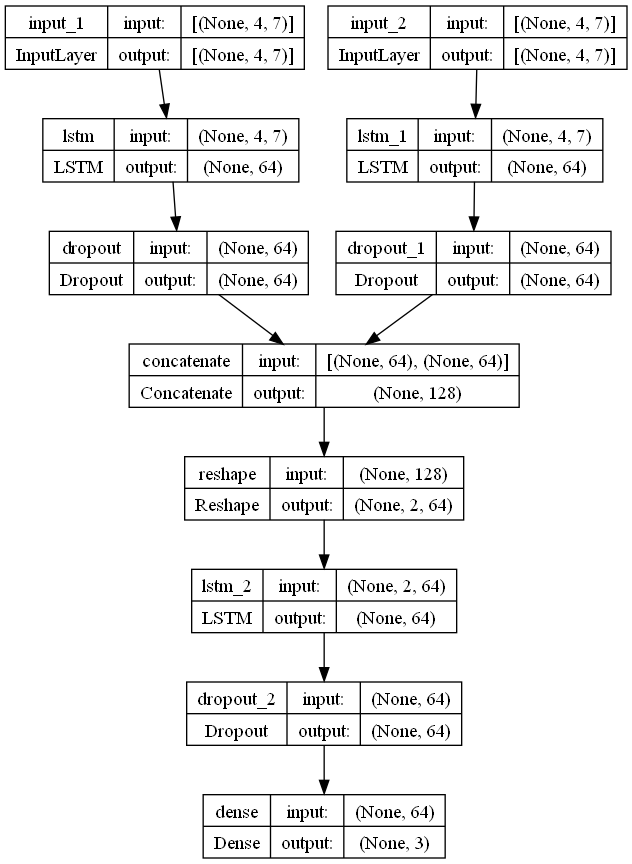

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_dtype=False)

In [29]:
x_val_home = x_val_home.astype(float)
x_val_away = x_val_away.astype(float)
x_val_hya = x_val_hya.astype(float)
x_train_home = x_train_home.astype('float32')
x_train_away = x_train_away.astype('float32')
x_train_hya = x_train_hya.astype('float32')

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Definir los callbacks
checkpoint = ModelCheckpoint("mejores_pesos.h5", monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=0)
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)

# Entrenar el modelo con los callbacks
history = model.fit(
    [x_train_home, x_train_away],
    y_train,
    epochs=110,
    batch_size=8,
    validation_data=([x_val_home, x_val_away], y_val),
    callbacks=[checkpoint]
)

 #Cargar los mejores pesos guardados
model.load_weights("mejores_pesos.h5")

# Obtener los datos de validación con los mejores pesos

Epoch 1/110
15/15 [==============================] - 2s 24ms/step - loss: 2.2200 - accuracy: 0.4454 - val_loss: 2.0223 - val_accuracy: 0.5098
Epoch 2/110
15/15 [==============================] - 0s 3ms/step - loss: 1.8803 - accuracy: 0.4958 - val_loss: 1.7301 - val_accuracy: 0.5098
Epoch 3/110
15/15 [==============================] - 0s 3ms/step - loss: 1.6209 - accuracy: 0.4958 - val_loss: 1.5112 - val_accuracy: 0.5098
Epoch 4/110
15/15 [==============================] - 0s 3ms/step - loss: 1.4262 - accuracy: 0.4958 - val_loss: 1.3427 - val_accuracy: 0.5098
Epoch 5/110
15/15 [==============================] - 0s 3ms/step - loss: 1.2803 - accuracy: 0.4958 - val_loss: 1.2321 - val_accuracy: 0.5098
Epoch 6/110
15/15 [==============================] - 0s 3ms/step - loss: 1.1874 - accuracy: 0.4958 - val_loss: 1.1632 - val_accuracy: 0.5098
Epoch 7/110
15/15 [==============================] - 0s 3ms/step - loss: 1.1280 - accuracy: 0.4958 - val_loss: 1.1193 - val_accuracy: 0.5098
Epoch 8/110


En este código se definen y utilizan callbacks durante el entrenamiento del modelo.

El callback ModelCheckpoint se utiliza para guardar los mejores pesos del modelo en un archivo llamado "mejores_pesos.h5". Se monitorea la métrica de precisión en el conjunto de validación (val_accuracy), y solo se guardan los pesos si se mejora esta métrica.

El modelo se entrena utilizando el método fit(), pasando los conjuntos de datos de entrenamiento y validación, el número de épocas (110 en este caso), el tamaño del lote (batch_size), y se incluye el callback ModelCheckpoint.

Una vez finalizado el entrenamiento, se cargan los mejores pesos guardados utilizando model.load_weights("mejores_pesos.h5"). Esto asegura que el modelo utilizado para predecir esté utilizando los mejores pesos obtenidos durante el entrenamiento.

Por último, se obtienen los datos de validación utilizando los mejores pesos del modelo para evaluar su rendimiento.

In [31]:
validation_results = model.evaluate([x_val_home, x_val_away], y_val, verbose=0)
print("Loss en datos de validación con los mejores pesos:", validation_results[0])
print("Precisión en datos de validación con los mejores pesos:", validation_results[1])

Loss en datos de validación con los mejores pesos: 1.0419570207595825
Precisión en datos de validación con los mejores pesos: 0.5686274766921997


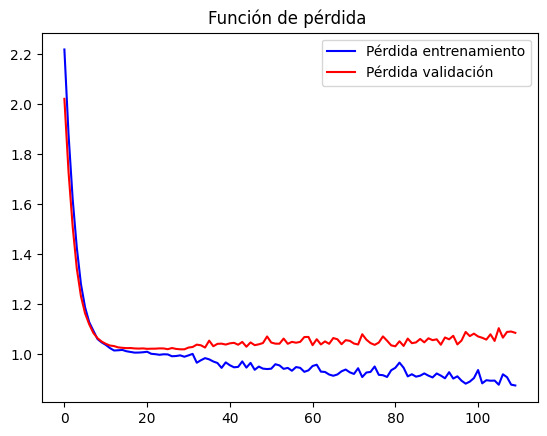

In [32]:
plot_train_history(history ,
                   'Función de pérdida ')

In [33]:
from sklearn.metrics import confusion_matrix

# Obtener las predicciones del modelo
predictions = model.predict([x_val_home, x_val_away])

# Obtener las etiquetas verdaderas
true_classes = np.argmax(y_val, axis=1)

# Obtener las clases predichas
predicted_classes = np.argmax(predictions, axis=1)

# Crear la matriz de confusión
confusion_mat = confusion_matrix(true_classes, predicted_classes)

# Imprimir la matriz de confusión
print(confusion_mat)

2/2 [==============================] - 0s 2ms/step
[[ 3  0 13]
 [ 1  0  8]
 [ 0  0 26]]


Se imprime la matriz de confusión utilizando print(confusion_mat). La matriz de confusión muestra la cantidad de muestras clasificadas correctamente e incorrectamente para cada clase.

In [34]:
print(predictions)

[[0.13310805 0.12962538 0.7372665 ]
 [0.24934055 0.1725959  0.5780635 ]
 [0.304582   0.21411349 0.4813045 ]
 [0.3657804  0.22866018 0.40555945]
 [0.272376   0.23519035 0.4924337 ]
 [0.07485852 0.11492206 0.8102194 ]
 [0.33282694 0.24755631 0.41961676]
 [0.30142316 0.24092373 0.45765308]
 [0.29355976 0.23951122 0.466929  ]
 [0.29632792 0.23882504 0.4648471 ]
 [0.29050624 0.23329392 0.4761998 ]
 [0.30243137 0.23207249 0.46549612]
 [0.23085707 0.20757668 0.5615662 ]
 [0.3081956  0.23197265 0.45983177]
 [0.3033239  0.23229212 0.464384  ]
 [0.27948886 0.22340865 0.4971026 ]
 [0.3285165  0.22681056 0.44467297]
 [0.34213436 0.2259791  0.43188652]
 [0.39025208 0.2170526  0.3926953 ]
 [0.24816655 0.20323762 0.5485958 ]
 [0.36883926 0.21465269 0.41650802]
 [0.36369818 0.21653143 0.41977042]
 [0.34569716 0.21499678 0.43930605]
 [0.3645642  0.21329099 0.4221448 ]
 [0.27198896 0.20314528 0.52486575]
 [0.3148161  0.20989923 0.47528473]
 [0.39829877 0.2033627  0.3983386 ]
 [0.3832905  0.20647852 0.41

In [35]:
index = np.unique(y_val)
index

array([False,  True])

<Axes: title={'center': 'Matrix de Confusion'}, xlabel='Predicted', ylabel='Actual'>

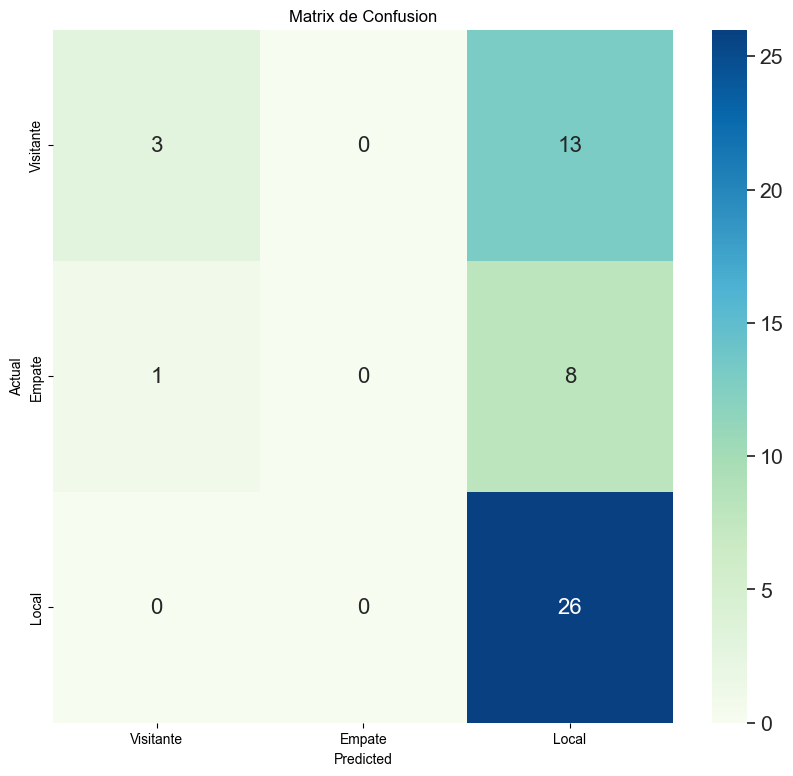

In [36]:

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


data = confusion_matrix( np.argmax(y_val, axis=1), np.argmax(predictions, axis=1))
df_cm = pd.DataFrame(data, ['Visitante','Empate','Local'], ['Visitante','Empate','Local'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,9))
plt.title('Matrix de Confusion')
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="GnBu", annot=True, fmt= 'g', annot_kws={"size": 16})

In [37]:
model.save("modelo.h5")

In [38]:
from tensorflow.keras.models import load_model

# Cargar el modelo
loaded_model = load_model("modelo.h5")

In [39]:
Visitante = input("Ingrese el equipo Visitante: ")

Ingrese el equipo Visitante:  Real Madrid


In [40]:
x_h=dfC['Barcelona'][0:4][:, 1:].astype('float32')
x_h = np.expand_dims(x_h, axis=0)


In [41]:
x_v=dfV[Visitante][0:4][:, 1:].astype('float32')
x_v = np.expand_dims(x_v, axis=0)


In [42]:
prediction= model.predict([x_h, x_v])

1/1 [==============================] - 0s 11ms/step


In [43]:
prediction

array([[0.2668499 , 0.20688897, 0.52626115]], dtype=float32)

In [44]:
# Obtener las probabilidades de ganar para cada equipo y de empate
prob_away_win = prediction[0][0]
prob_draw = prediction[0][1]
prob_home_win = prediction[0][2]

# Imprimir los resultados
print("Probabilidades de resultado:")
print('Barca', "gana:", prob_home_win)
print(Visitante, "gana:", prob_away_win)
print("Empate:", prob_draw)

Probabilidades de resultado:
Barca gana: 0.52626115
Real Madrid gana: 0.2668499
Empate: 0.20688897
